In [1]:
# change directory
import os
rootdir = os.path.dirname(os.getcwd())
os.chdir(rootdir)

# import third libs for data
import datetime as dt
import numpy as np
import pandas as pd

# import config
from config import DATA_DIR

# Chargement des donnees

In [2]:
benchmarkname = 'HGD_dialysis_2018_2021'
benchmarkdir = os.path.join(DATA_DIR, 'raw', benchmarkname)
benchmarkdir

'D:\\Recherches\\Travaux\\RCEMP\\rcemp-dial\\data\\raw\\HGD_dialysis_2018_2021'

## chargement des seances

In [3]:
datapath = os.path.join(benchmarkdir, 'donnees_seances.csv')
seances = pd.read_csv(datapath, sep=';', index_col='Date', parse_dates=True, dayfirst=True)
seances.head()

,ID,Tour,Patients,Debut,Duree
Date,,,,,
2018-03-26,1,Tour1,21,5,5
2018-03-26,2,Tour2,21,10,5
2018-03-26,3,Tour3,21,15,5
2018-03-26,4,Tour4,8,20,5
2018-03-27,5,Tour1,21,5,5


In [4]:
seances.dtypes

ID           int64
Tour        object
Patients     int64
Debut        int64
Duree        int64
dtype: object

## chargement des generateurs

In [5]:
datapath = os.path.join(benchmarkdir, 'donnees_generateurs.csv')
generateurs = pd.read_csv(datapath, sep=';', index_col='Numero')
generateurs.head()

,Code,TT,TO,TNR,TR,TAP,TF,TE,TN,TU,TRE,TRSi
Numero,,,,,,,,,,,,
1,7SXAWU98,30576,22932,932,22000,6301.08,15698.92,4.92,15694,15694,0,NaN
2,7SXAWT97,30576,22932,932,22000,19262.22,2737.78,1.78,2736,2736,0,NaN
3,7SXAWU81,30576,22932,932,22000,9462.73,12537.27,1.27,12536,12536,0,NaN
4,7SXAWU91,30576,22932,932,22000,7857.71,14142.29,2.29,14140,14140,0,NaN
5,7SXAWS81,30576,22932,932,22000,5639.52,16360.48,4.48,16356,16356,0,NaN


In [6]:
generateurs.dtypes

Code     object
TT        int64
TO        int64
TNR       int64
TR        int64
TAP     float64
TF      float64
TE      float64
TN        int64
TU        int64
TRE       int64
TRSi    float64
dtype: object

In [7]:
generateurs.Code.sort_values()

Numero
24      6SX4LV10
21      7SXAWS80
5       7SXAWS81
20      7SXAWS82
2       7SXAWT97
8       7SXAWT98
14      7SXAWU79
17      7SXAWU80
3       7SXAWU81
12      7SXAWU82
22      7SXAWU83
18      7SXAWU84
19    7SXAWU85-A
23    7SXAWU85-B
9       7SXAWU86
7       7SXAWU87
11      7SXAWU89
16      7SXAWU90
4       7SXAWU91
15      7SXAWU93
13      7SXAWU94
6       7SXAWU96
10      7SXAWU97
1       7SXAWU98
Name: Code, dtype: object

# Identification des patients

Constante utilisee pour l'identification des patients:

- $\delta_1$  duree du cycle de planification
- $\delta_2$  duree du repos entre traitement
- $\alpha_1$  le nombre de seance par cycle pour un patient 

Notons:

- $P$ le nombre de patients par cycle
- $S$ le nombre de seance effective par cycle

On a :   $ \alpha_1 P = S $

**NB: il existe des cas exceptionnel et marginal ou le nombre de seances est augmente par le medecin au vu de l'etat d'un patient. On considere dans cette exemple que ces cas sont marginaux. Il existe aussi des patients non enregistree qui viennent pour une dialyse de passage**

In [8]:
delta_1 = 1
delta_2 = 24
alpha_1 = 2

## calcul du nombre de seances par cycles

In [9]:
sampling = '%sW' % delta_1
nb_seances = seances['Patients'].resample(sampling).sum()
nb_seances.name = 'seance_effective'
nb_seances.head()

Date
2018-04-01    410
2018-04-08    408
2018-04-15    416
2018-04-22    408
2018-04-29    408
Freq: W-SUN, Name: seance_effective, dtype: int64

## calcul du nombre de patients par cycles

In [10]:
nb_patients = nb_seances // alpha_1
nb_patients.name = 'nb_patient'
nb_patients.head()

Date
2018-04-01    205
2018-04-08    204
2018-04-15    208
2018-04-22    204
2018-04-29    204
Freq: W-SUN, Name: nb_patient, dtype: int64

In [11]:
patients = pd.concat([nb_seances, nb_patients], axis=1)
patients.head()

,seance_effective,nb_patient
Date,,
2018-04-01,410,205
2018-04-08,408,204
2018-04-15,416,208
2018-04-22,408,204
2018-04-29,408,204


## calcul du nombre de seances par tours

In [12]:
tours = []
for i in range(1, 5):
    filter_ = 'Tour%s' % i
    tour = seances[seances.Tour == filter_]['Patients']
    tour.name = 'patient_tour%s' % i
    tours.append(tour)
tours = pd.concat(tours, axis=1)
tours.head()

,patient_tour1,patient_tour2,patient_tour3,patient_tour4
Date,,,,
2018-03-26,21,21,21,8
2018-03-27,21,21,21,9
2018-03-28,21,21,21,5
2018-03-29,21,21,21,4
2018-03-30,21,21,21,9


## calcul des preferences temporelles des patients

In [13]:
tours_cycles = tours.resample(sampling).sum()
# tours_cycles = tours_cycles.iloc[-nb_cycles:]
tours_cycles['patient_total'] = tours_cycles.sum(axis=1)
tours_cycles.head()

,patient_tour1,patient_tour2,patient_tour3,patient_tour4,patient_total
Date,,,,,
2018-04-01,126,126,123,35,410
2018-04-08,126,126,124,32,408
2018-04-15,126,126,125,39,416
2018-04-22,125,126,117,40,408
2018-04-29,126,126,117,39,408


<Axes: xlabel='Cycles'>

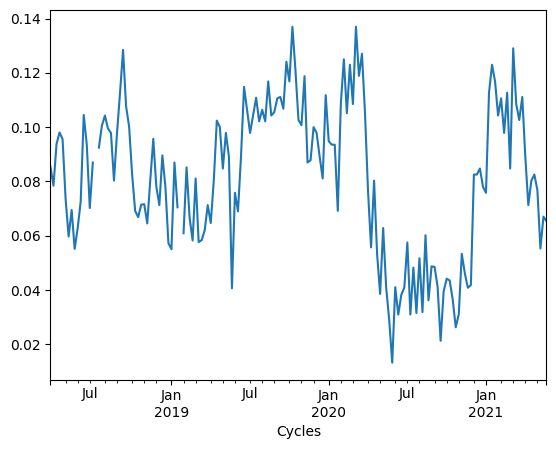

In [14]:
tours_cycles['taux_insatisfaction'] = tours_cycles['patient_tour4'] / tours_cycles['patient_total']
tours_cycles['taux_insatisfaction'].plot(xlabel='Cycles')

In [15]:
tours_matin = tours_cycles['patient_tour1'] + tours_cycles['patient_tour2'] 
tours_matin += tours_cycles['taux_insatisfaction'] * tours_cycles['patient_tour3'] 
tours_matin.head()

Date
2018-04-01    262.500000
2018-04-08    261.725490
2018-04-15    263.718750
2018-04-22    262.470588
2018-04-29    263.183824
Freq: W-SUN, dtype: float64

In [16]:
patients_matin = tours_matin // alpha_1
patients_matin.head()

Date
2018-04-01    131.0
2018-04-08    130.0
2018-04-15    131.0
2018-04-22    131.0
2018-04-29    131.0
Freq: W-SUN, dtype: float64

In [17]:
patients['preference_matin'] = patients_matin
patients['preference_soir'] = patients['nb_patient'] - patients_matin
patients.head()

,seance_effective,nb_patient,preference_matin,preference_soir
Date,,,,
2018-04-01,410,205,131.0,74.0
2018-04-08,408,204,130.0,74.0
2018-04-15,416,208,131.0,77.0
2018-04-22,408,204,131.0,73.0
2018-04-29,408,204,131.0,73.0


<Axes: title={'center': 'Preference des patients'}, xlabel='Cycle'>

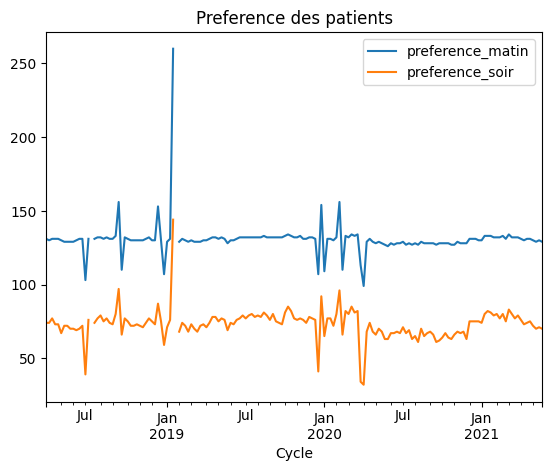

In [18]:
patients[['preference_matin', 'preference_soir']].plot(title='Preference des patients', xlabel='Cycle')

## verification du nombre de seances obtenues

In [19]:
patients['seance_theorique'] = alpha_1 * patients['nb_patient']
patients['seance_aleatoire'] = patients['seance_effective'] - patients['seance_theorique']
patients.head()

,seance_effective,nb_patient,preference_matin,preference_soir,seance_theorique,seance_aleatoire
Date,,,,,,
2018-04-01,410,205,131.0,74.0,410,0
2018-04-08,408,204,130.0,74.0,408,0
2018-04-15,416,208,131.0,77.0,416,0
2018-04-22,408,204,131.0,73.0,408,0
2018-04-29,408,204,131.0,73.0,408,0


In [20]:
patients['seance_aleatoire'].value_counts()

0    88
1    77
Name: seance_aleatoire, dtype: int64

## visualisation des seances et patients

<Axes: title={'center': 'Nombre de session theorique et effective'}, xlabel='Cycle'>

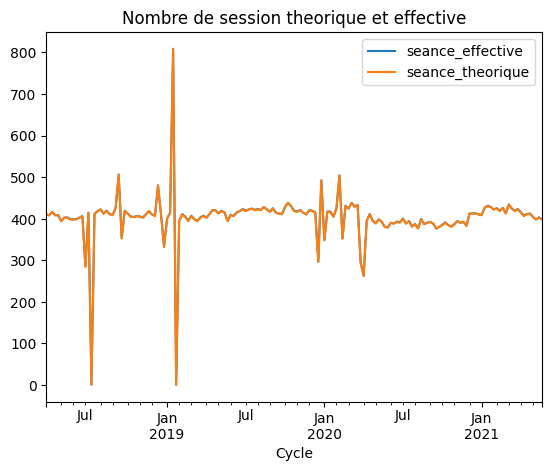

In [21]:
patients[['seance_effective', 'seance_theorique']].plot(title='Nombre de session theorique et effective', xlabel='Cycle')

<Axes: title={'center': 'Nombre de patients par cycle'}, xlabel='Cycle'>

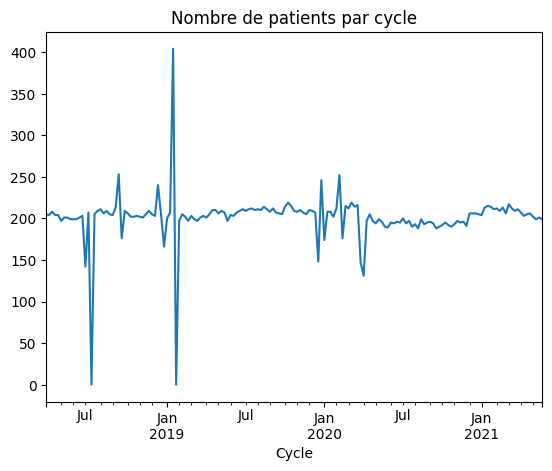

In [22]:
patients['nb_patient'].plot(title='Nombre de patients par cycle', xlabel='Cycle')

In [23]:
patients[patients.nb_patient==0]

,seance_effective,nb_patient,preference_matin,preference_soir,seance_theorique,seance_aleatoire
Date,,,,,,
2018-07-15,0,0,NaN,NaN,0,0
2019-01-27,0,0,NaN,NaN,0,0


## selection de l'echantillon des patients
on choisit les periodes ou des patients sont traites

In [24]:
patients = patients[patients.nb_patient>0]

## enregistrement des parametres des patients

In [25]:
patients['nb_seance_par_patient'] = alpha_1
patients['duree_cycle'] = delta_1
patients['duree_repos'] = delta_2
patients['duree_seance'] = 5
patients.head()

,seance_effective,nb_patient,preference_matin,preference_soir,seance_theorique,seance_aleatoire,nb_seance_par_patient,duree_cycle,duree_repos,duree_seance
Date,,,,,,,,,,
2018-04-01,410,205,131.0,74.0,410,0,2,1,24,5
2018-04-08,408,204,130.0,74.0,408,0,2,1,24,5
2018-04-15,416,208,131.0,77.0,416,0,2,1,24,5
2018-04-22,408,204,131.0,73.0,408,0,2,1,24,5
2018-04-29,408,204,131.0,73.0,408,0,2,1,24,5


In [26]:
patientpath = os.path.join(benchmarkdir, 'parametres_patients.csv')
patients.to_csv(patientpath)

In [27]:
# tourpath = os.path.join(benchmarkdir, 'tours.csv')
# tours.to_csv(tourpath)

# Identification des machines

Notons:

- $\delta_3$ duree traitement pour une seance et une machine en heure
- $\delta_4$ duree demarrage journaliere en heure
- $\delta_5$ nombre d'heures avant maintenance systematique des filtres
- $\delta_6$ nombre d'heures avant maintenance systematique generale
- $\alpha_2$ nombre de lits qui indique le nombre de machines utiles


In [28]:
# pour freysinus
delta_3 = 4
delta_4 = 5 * 4
delta_5 = 2 * 7 * 24                # 2 semaines
delta_6 = 365 * 24                  # 1 an
alpha_2 = 21                        

## calcul de la repartition des charges entre machines

In [29]:
nb_patients = patients['seance_effective'].sum()
temps_total_theorique = nb_patients * delta_3
temps_total_theorique

266164

In [30]:
temps_effectif = generateurs['TF']
temps_total_effectif = temps_effectif.sum()
temps_total_effectif

286763.1

In [31]:
repartition = temps_effectif / temps_total_effectif
repartition.head()

Numero
1    0.054745
2    0.009547
3    0.043720
4    0.049317
5    0.057052
Name: TF, dtype: float64

## calcul des temps de fonctionnement par periodes

In [32]:
temps_echantillon = repartition * temps_total_theorique
temps_echantillon.head()

Numero
1    14571.216948
2     2541.116608
3    11636.678263
4    13126.404602
5    15185.255002
Name: TF, dtype: float64

In [33]:
temps_origine = temps_effectif - temps_echantillon
temps_origine.head()

Numero
1    1127.703052
2     196.663392
3     900.591737
4    1015.885398
5    1175.224998
Name: TF, dtype: float64

In [34]:
cumul_seance = patients['seance_effective'].cumsum()
cumul_seance.name = 'seance_cumulee'
cumul_seance

Date
2018-04-01      410
2018-04-08      818
2018-04-15     1234
2018-04-22     1642
2018-04-29     2050
              ...  
2021-04-25    64938
2021-05-02    65342
2021-05-09    65740
2021-05-16    66143
2021-05-23    66541
Name: seance_cumulee, Length: 163, dtype: int64

## calcul des dates de mise en service

In [35]:
base_t = dt.datetime(2015, 12, 31)
first_t = seances.index[0]
last_t = patients.index[-1]
base_t, first_t, last_t

(datetime.datetime(2015, 12, 31, 0, 0),
 Timestamp('2018-03-26 00:00:00'),
 Timestamp('2021-05-23 00:00:00'))

In [36]:
# hour = pd.tseries.offsets.Hour()
# total_hours = generateurs['TT'].iloc[0]
# base_t = last_t - total_hours * hour
# base_t, total_hours

In [37]:
# periodes = seances['Tour'].groupby(level=0).count()
# periodes

In [38]:
last_t.dayofweek

6

## calcul des durees de vie des machines

In [39]:
jours = pd.date_range(base_t, last_t, freq='D')
jours

DatetimeIndex(['2015-12-31', '2016-01-01', '2016-01-02', '2016-01-03',
               '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-09',
               ...
               '2021-05-14', '2021-05-15', '2021-05-16', '2021-05-17',
               '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
               '2021-05-22', '2021-05-23'],
              dtype='datetime64[ns]', length=1971, freq='D')

In [40]:
duree_jours = pd.Series(24, index=jours)
duree_cumulee = duree_jours.cumsum()
duree_cumulee

2015-12-31       24
2016-01-01       48
2016-01-02       72
2016-01-03       96
2016-01-04      120
              ...  
2021-05-19    47208
2021-05-20    47232
2021-05-21    47256
2021-05-22    47280
2021-05-23    47304
Freq: D, Length: 1971, dtype: int64

In [41]:
# duree_seances = pd.Series(delta_4, index=periodes.index)
# duree_seances

In [42]:
# duree_cycles  = duree_seances.resample(sampling).sum()
# duree_cycles.head()

In [43]:
# duree_echantillon = duree_seances.sum()
# duree_finale = total_hours
# duree_initiale = duree_finale - duree_echantillon
# duree_initiale, duree_finale

In [44]:
# duree_cumulee = duree_cycles.cumsum()
# duree_cumulee += duree_initiale
# duree_cumulee

## creation des parametres de machines

In [45]:
generateurs.columns

Index(['Code', 'TT', 'TO', 'TNR', 'TR', 'TAP', 'TF', 'TE', 'TN', 'TU', 'TRE',
       'TRSi'],
      dtype='object')

In [46]:
machines = []
code_machines = generateurs['Code']
for time in cumul_seance.index:
    seance_machines = repartition * cumul_seance.loc[time]
    temps_machines = temps_origine + delta_3 * seance_machines
    temps_machines.name = 'duree_usage'
    cols = [code_machines, temps_machines]
    machines_period = pd.concat(cols, axis=1)
    machines_period['periode'] = time
    machines_period['duree_vie'] = duree_cumulee.loc[time]
    machines_period['delai_maintenance_filtre'] = delta_5
    machines_period['delai_maintenance_generale'] = delta_6  
    machines_echantillon = machines_period.sample(n=alpha_2, weights=repartition)
    machines.append(machines_echantillon)
machines = pd.concat(machines)
machines
    

,Code,duree_usage,periode,duree_vie,delai_maintenance_filtre,delai_maintenance_generale
Numero,,,,,,
18,7SXAWU84,1220.795977,2018-04-01,19752,336,8760
13,7SXAWU94,1308.740911,2018-04-01,19752,336,8760
19,7SXAWU85-A,1212.525814,2018-04-01,19752,336,8760
10,7SXAWU97,1142.167386,2018-04-01,19752,336,8760
5,7SXAWS81,1268.790687,2018-04-01,19752,336,8760
...,...,...,...,...,...,...
8,7SXAWT98,1576.940000,2021-05-23,47304,336,8760
2,7SXAWT97,2737.780000,2021-05-23,47304,336,8760
16,7SXAWU90,16727.930000,2021-05-23,47304,336,8760


In [47]:
24 * 365


8760

## verification des calculs de temps de fonctionnement

In [48]:
period_test = cumul_seance.index[-1]
machines_test = machines[machines.periode==period_test]
machines_test = machines_test[['Code', 'duree_usage']]
generateurs_test = generateurs[['Code', 'TF']]
test = pd.merge(machines_test, generateurs_test, on='Code')
test.head()

,Code,duree_usage,TF
0,7SXAWS80,15120.79,15120.79
1,7SXAWU79,15369.35,15369.35
2,7SXAWU93,14125.42,14125.42
3,7SXAWU98,15698.92,15698.92
4,7SXAWU85-B,15343.58,15343.58


## selection des machines
equivalence machines et nombres de lits

In [49]:
# Weights will be re-normalized automatically
# test_weights = [0.2, 0.2, 0.2, 0.4]
# df1.sample(n=3, weights=test_weights)
generateurs.sample(n=alpha_2, weights=generateurs.TU)

,Code,TT,TO,TNR,TR,TAP,TF,TE,TN,TU,TRE,TRSi
Numero,,,,,,,,,,,,
16,7SXAWU90,30576,22932,932,22000,5272.07,16727.93,3.93,16724,16724,0,NaN
13,7SXAWU94,30576,22932,932,22000,5124.38,16875.62,3.62,16872,16872,0,NaN
1,7SXAWU98,30576,22932,932,22000,6301.08,15698.92,4.92,15694,15694,0,NaN
21,7SXAWS80,30576,22932,932,22000,6879.21,15120.79,4.79,15116,15116,0,NaN
19,7SXAWU85-A,30576,22932,932,22000,6365.03,15634.97,2.97,15632,15632,0,NaN
17,7SXAWU80,30576,22932,932,22000,6363.02,15636.98,0.98,15636,15636,0,NaN
3,7SXAWU81,30576,22932,932,22000,9462.73,12537.27,1.27,12536,12536,0,NaN
6,7SXAWU96,30576,22932,932,22000,7826.20,14173.80,1.80,14172,14172,0,NaN
4,7SXAWU91,30576,22932,932,22000,7857.71,14142.29,2.29,14140,14140,0,NaN


## enregistrement des parametres de machines

In [50]:
machinepath = os.path.join(benchmarkdir, 'parametres_machines.csv')
machines.to_csv(machinepath)

In [51]:
machines.dtypes

Code                                  object
duree_usage                          float64
periode                       datetime64[ns]
duree_vie                              int64
delai_maintenance_filtre               int64
delai_maintenance_generale             int64
dtype: object

# Identification des tranches horaires

In [52]:
heures = ['%sH-%sH' % (i, i+1) for i in range(24)]
jours = ['D%s' % (j+1) for j in range(7)]
tranches = pd.DataFrame(data='--', index=heures, columns=jours)
tranches.index.name = 'Period'
tranches

,D1,D2,D3,D4,D5,D6,D7
Period,,,,,,,
0H-1H,--,--,--,--,--,--,--
1H-2H,--,--,--,--,--,--,--
2H-3H,--,--,--,--,--,--,--
3H-4H,--,--,--,--,--,--,--
4H-5H,--,--,--,--,--,--,--
5H-6H,--,--,--,--,--,--,--
6H-7H,--,--,--,--,--,--,--
7H-8H,--,--,--,--,--,--,--
8H-9H,--,--,--,--,--,--,--


## calculs des tranches de soins pour patients

In [53]:
tranches_soins = tranches.copy()
tranches_soins.iloc[5:10, :6] = 'soins1'
tranches_soins.iloc[10:15, :6] = 'soins2'
tranches_soins.iloc[15:20, :6] = 'soins3'
tranches_soins.iloc[20:24, :6] = 'soins4'
tranches_soins.iloc[0:1, 1:7] = 'soins4'
tranches_soins

,D1,D2,D3,D4,D5,D6,D7
Period,,,,,,,
0H-1H,--,soins4,soins4,soins4,soins4,soins4,soins4
1H-2H,--,--,--,--,--,--,--
2H-3H,--,--,--,--,--,--,--
3H-4H,--,--,--,--,--,--,--
4H-5H,--,--,--,--,--,--,--
5H-6H,soins1,soins1,soins1,soins1,soins1,soins1,--
6H-7H,soins1,soins1,soins1,soins1,soins1,soins1,--
7H-8H,soins1,soins1,soins1,soins1,soins1,soins1,--
8H-9H,soins1,soins1,soins1,soins1,soins1,soins1,--


## calculs des tranches de maintenances des machines

In [54]:
tranches_maintenances = tranches.copy()
tranches_maintenances.iloc[7:17, :6] = 'service'
tranches_maintenances

,D1,D2,D3,D4,D5,D6,D7
Period,,,,,,,
0H-1H,--,--,--,--,--,--,--
1H-2H,--,--,--,--,--,--,--
2H-3H,--,--,--,--,--,--,--
3H-4H,--,--,--,--,--,--,--
4H-5H,--,--,--,--,--,--,--
5H-6H,--,--,--,--,--,--,--
6H-7H,--,--,--,--,--,--,--
7H-8H,service,service,service,service,service,service,--
8H-9H,service,service,service,service,service,service,--


## enregistrement des tranches horaires

In [55]:
tranchepath = os.path.join(benchmarkdir, 'tranches_soins.csv')
tranches_soins.to_csv(tranchepath)

In [56]:
tranchepath = os.path.join(benchmarkdir, 'tranches_maintenances.csv')
tranches_maintenances.to_csv(tranchepath)